In [17]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
import sys
sys.path.append('.')
import PQS_solver as PQS
from iminuit import Minuit
from iminuit.cost import LeastSquares
from matplotlib.ticker import MultipleLocator

In [18]:
N_m_strength = 5 # Number if different magnetic momnent strengths
N_theta = 1 # Number of different angles of the magnetic moment
N_states = N_m_strength * N_theta # number of different singnal states
t_gamma = 50 # time of the simulation
gamma = 1 # characteristic decay rate
t = t_gamma / gamma # time of the simulation
dt = 0.001 # time step of the simulation
N_t = int(t / dt + 1) # number of time steps
times = np.linspace(0, t, N_t, endpoint=True) # time steps
mu1 = 1 # magnetic moment of the qubit
mu2 = 1 # magnetic moment of thee_op = lambda i : [c_out_1_1_e(i) + c_out_1_2_e(i).dag(), c_out_1_1_e_dag(i) + c_out_1_2_e_dag(i).dag()] qubit
seed_signal = 46 # seed for random number generator for the signal
seed_simulation = 9 # seed for random number generator for the simulation
t_signal_leadin = 1 # time for the stocastic nature of the signal to not be at 0 as the begining of the simulation
gamma_decay = gamma # decay rate of qubit out of cavity
gamma_phi = gamma # dephasing rate of qubit
m_min, m_max = 4.9, 5.1 # range of the magnetic moment

m_step = (m_max - m_min) / N_m_strength
theta_min, theta_max = 0, 0#-1/10 * np.pi, 1/10 * np.pi # range of the angle of the magnetic moment
# true angle of the magnetic moment
methode = 'Kraus' # methode used for the ODE solver
p = 0.02 * gamma # transition rate 

field_type = 'uniform' # 'dipole' type of sensing field


save=False


dephase_strength = 0.00
entaglement = 'entangled' # 'entangled' or 'seperable' entangled state




beta_1 = np.array([1, 0, 0]) # amplitude of driving field
beta_2 = np.array([0, 1, 0]) # amplitude of driving field

cupling_strength = 0.0

# Simulate Signal

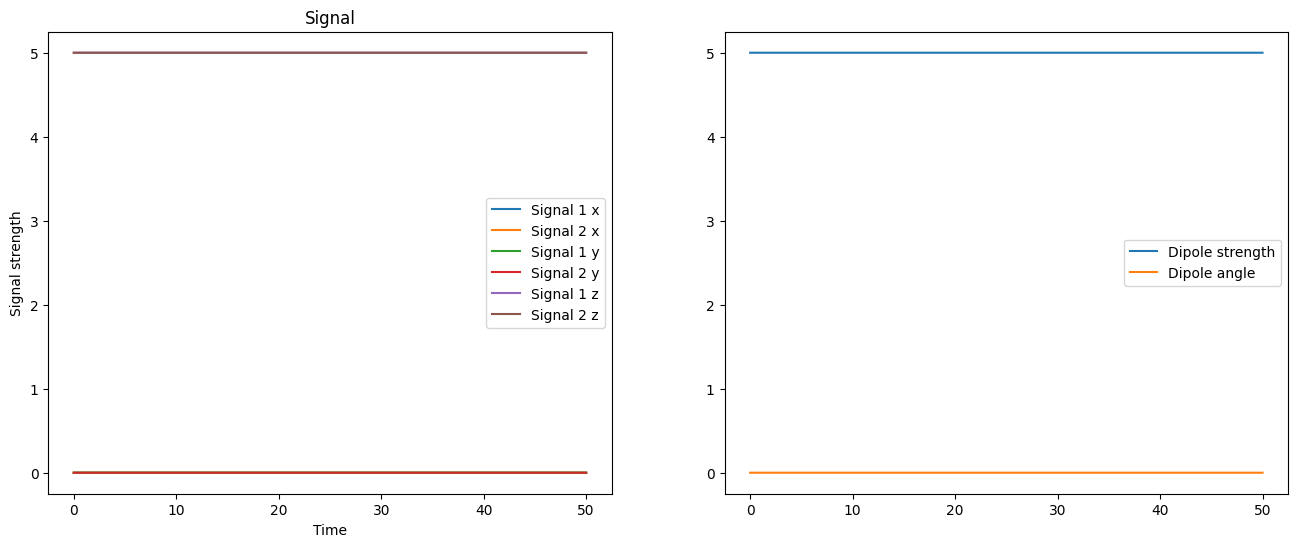

In [19]:
r_signal = np.random.default_rng(seed_signal) # random number generator for the signal
N_t_leadin = int(t_signal_leadin / dt) # number of time steps for the leadin of the signal



def magnetic_field(r, m):
    """The magnetic field at position r due to a magnetic dipole m. The magnetic moment is in units of mu_0"""
    r_norm = np.sqrt(np.dot(r, r))

    
    
    B = 1 / (4 * np.pi) * (3 * np.dot(m, r) * r / (r_norm**5) - m / (r_norm**3))
    
    return B




R_1 = np.array([0, 1, 0])
R_2 = np.array([1, 0, 0])

R_m = np.array([0, 0, 0])





m_strength_posible = np.linspace(m_min, m_max, N_m_strength)
#m_strength_index = r_signal.randint(N_m_strength)
#m_strength = m_strength_posible[m_strength_index] # magnetic moment strength

theta_posible = np.linspace(theta_min, theta_max, N_theta)
#theta_index = r_signal.randint(N_theta)
#theta = theta_posible[theta_index] # angle of the magnetic moment

#m = m_strength * np.array([0, np.cos(theta), np.sin(theta)]) # magnetic moment


B_1 = np.zeros((N_t + N_t_leadin, 3))
B_2 = np.zeros((N_t + N_t_leadin, 3))


# The ordering of the states in the markov model will be as folows, all of the field strenghts for the first angle, then all of the field strengths for the second angle, and so on

m_mesh, theta_mesh = np.meshgrid(m_strength_posible, theta_posible)
m_mesh = m_mesh.flatten()
theta_mesh = theta_mesh.flatten()

HMM_state_index = np.zeros(N_t + N_t_leadin, dtype=int) # the index of the HMM state at each time step
HMM_state_index[0] = int(N_states / 2) #r_signal.integers(0, N_states) # the initial state of the HMM

#print('theta mesh',theta_mesh)

B_1_posible = np.zeros((N_states, 3))
B_2_posible = np.zeros((N_states, 3))


def rotation_matrix(theta, axis):
    """The rotation matrix for a rotation of theta around the axis"""
    axis = axis / np.linalg.norm(axis)
    a = np.cos(theta / 2)
    b, c, d = -axis * np.sin(theta / 2)
    return np.array([[a**2 + b**2 - c**2 - d**2, 2 * (b * c - a * d), 2 * (b * d + a * c)],
                     [2 * (b * c + a * d), a**2 + c**2 - b**2 - d**2, 2 * (c * d - a * b)],
                     [2 * (b * d - a * c), 2 * (c * d + a * b), a**2 + d**2 - b**2 - c**2]])

unit_vector_x = np.array([1, 0, 0])
unit_vector_y = np.array([0, 1, 0])
unit_vector_z = np.array([0, 0, 1])


unit_vectors_rotated = np.zeros((N_states, 3))

#print('test of rotation matrix', rotation_matrix(np.pi / 2, np.array([1, 0, 0])) @ np.array([0, 0, 1]))

if field_type == 'dipole':
    for i in range(N_states):
        B_1_posible[i] = magnetic_field(R_1, rotation_matrix(theta_mesh[i], unit_vector_z) @ unit_vector_x * m_mesh[i])
        B_2_posible[i] = magnetic_field(R_2, rotation_matrix(theta_mesh[i], unit_vector_z) @ unit_vector_x * m_mesh[i])
    #unit_vectors_rotated[i] = unit_vector_z @ rotation_matrix(theta_mesh[i], np.array([1, 0, 0]))

elif field_type == 'uniform':
    for i in range(N_states):
        B_1_posible[i] = rotation_matrix(theta_mesh[i], unit_vector_x) @ unit_vector_z * m_mesh[i] 
        B_2_posible[i] = rotation_matrix(theta_mesh[i], unit_vector_x) @ unit_vector_z * m_mesh[i]
    #unit_vectors_rotated[i] = unit_vector_z @ rotation_matrix(theta_mesh[i], np.array([1, 0, 0]))

#print('B1 posibble', np.max(B_1_z_posible))
#print('B2 posible' ,np.max(B_2_z_posible))
    #B_1_z[i] = B_1_z_posible[nr - 1]




 
B_1[0] = B_1_posible[HMM_state_index[0]]
B_2[0] = B_2_posible[HMM_state_index[0]]

#fig, ax = plt.subplots(1, figsize=(16, 6))
#ax.plot(m_mesh, theta_mesh, '.', label='unitvector rotated')
#ax.show()


st = 0.0 # to regulate the transtion rate between HMM states

def gennerate_r_next_neighbour_jump(N, st):
    r = np.eye(N, k=0) * (1 - 2 * st)
    r += np.eye(N, k=1) * st
    r += np.eye(N, k=-1) * st
    r[0, 0] = 1 - st
    r[-1, -1] = 1 - st
    return r

r_HMM = gennerate_r_next_neighbour_jump(N_states, st)


#st = 0.0 # to regulate the transtion rate between HMM states

#r_HMM = np.ones((N_states, N_states)) * st 




#r_HMM_sim = np.zeros((N_states, N_states))

#for i in range(N_states):
#    for j in range(N_states):
#        if i != j:
#            r_HMM_sim[i, j] = r_HMM[i, j] * dt

#for i in range(N_states):
#    r_HMM_sim[i, i] = 1 - np.sum(r_HMM_sim[i, :])




# generate the signal
r_HMM_sim = np.zeros((N_states, N_states))

for i in range(N_states):
    for j in range(N_states):
        if i != j:
            r_HMM_sim[i, j] = r_HMM[i, j] * dt

for i in range(N_states):
    r_HMM_sim[i, i] = 1 - np.sum(r_HMM_sim[i, :])


# generate the signal
for i in range(1, N_t_leadin + N_t):
    q = r_signal.random()
    prob_sum = 0
    nr = 0
    while prob_sum < q:
        prob_sum += r_HMM_sim[HMM_state_index[i - 1], nr]
        nr += 1
    HMM_state_index[i] = nr - 1



HMM_state_index_new = HMM_state_index[N_t_leadin:] # remove the leadin of the signal

B_1 = B_1_posible[HMM_state_index_new]
B_2 = B_2_posible[HMM_state_index_new]
    
m_t = m_mesh[HMM_state_index_new]
theta_t = theta_mesh[HMM_state_index_new]




#B_1_z_new = B_1_z[N_t_leadin:] # remove the leadin of the signal
#B_2_z_new = B_2_z[N_t_leadin:] # remove the leadin of the signal
HMM_state_index_new = HMM_state_index[N_t_leadin:] # remove the leadin of the signal
#dW = dW[N_t_leadin:] # remove the leadin of the Wiener process
Delta_n_1 = B_1 * mu1 # signal, rounded to the nearest integer as the ME simulationonly works for a descrete set of signal strengths
Delta_n_2 = B_2 * mu2 # signal, rounded to the nearest integer as the ME simulationonly works for a descrete set of signal strengths

Delta_n_1_posible = B_1_posible * mu1
Delta_n_2_posible = B_2_posible * mu2

#print(HMM_state_index_new)
#print('B1 posibble', B_1)
#print('B2 posible' ,B_2)


fig, ax = plt.subplots(1, 2, figsize=(16, 6))

t_plot = np.linspace(0, t * gamma, N_t)

Blues = plt.get_cmap('Blues')

labels = ['x', 'y', 'z']
for i in range(3):
    ax[0].plot(t_plot, Delta_n_1[:,i], label=f'Signal 1 {labels[i]}')
    ax[0].plot(t_plot, Delta_n_2[:,i], label=f'Signal 2 {labels[i]}')
ax[1].plot(t_plot, m_t, label='Dipole strength')
ax[1].plot(t_plot, theta_t, label='Dipole angle')
ax[0].set_title('Signal')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Signal strength')

#ax[1].set_title('Wiener process')
#ax[1].plot(t_plot, dW)
ax[0].legend()
ax[1].legend()
plt.show()




# 2. Simulate detection record

In [20]:
gamma_purcell = lambda Delta_n : 2 * g ** 2 * kappa / (kappa ** 2 + (Delta_r - Delta_n) ** 2)

#N = 1
kappa = 10 * gamma # amplitude decay rate of cavity field due to transmission of the output field
kappa_1 = kappa # amplitude decay rate of cavity field due to loss
Delta_r = 0 # cavity detuning
g = 5 * gamma # coupling strength
#alpha = np.sqrt(2 * kappa) * beta / (kappa + 1j * Delta_r)
epsilon_n_1 = g ** 2 * (Delta_r - Delta_n_1) / (kappa ** 2 + (Delta_r - Delta_n_1)** 2)
epsilon_n_2 = g ** 2 * (Delta_r - Delta_n_2) / (kappa ** 2 + (Delta_r - Delta_n_2)** 2)


#noise_factor = 0.004
noise_factor = 1

N_dim = 2


# be warned. Since jmat is used, the factor of 1/2 is inside the jmat function
sigma_z = qt.jmat(N_dim/2 - 1/2, 'z')#qt.sig maz()# Pauli-Z operator for qubit
sigma_x = qt.jmat(N_dim/2 - 1/2, 'x')#qt.sigmax() # Pauli-X operator for qubit
sigma_y = qt.jmat(N_dim/2 - 1/2, 'y')#qt.sigmay() # Pauli-Y operator for qubit
sigma_p = qt.jmat(N_dim/2 - 1/2, '+')#qt.sigmap() # raising operator for qubit
sigma_m = qt.jmat(N_dim/2 - 1/2, '-')#qt.sigmam() # lowering operator for qubit



sigma_z_1 = qt.tensor(sigma_z, qt.qeye(N_dim))
sigma_x_1 = qt.tensor(sigma_x, qt.qeye(N_dim))
sigma_y_1 = qt.tensor(sigma_y, qt.qeye(N_dim))
sigma_p_1 = qt.tensor(sigma_p, qt.qeye(N_dim))
sigma_m_1 = qt.tensor(sigma_m, qt.qeye(N_dim))

sigma_z_2 = qt.tensor(qt.qeye(N_dim), sigma_z)
sigma_x_2 = qt.tensor(qt.qeye(N_dim), sigma_x)
sigma_y_2 = qt.tensor(qt.qeye(N_dim), sigma_y)
sigma_p_2 = qt.tensor(qt.qeye(N_dim), sigma_p)
sigma_m_2 = qt.tensor(qt.qeye(N_dim), sigma_m)


c_x = qt.Qobj([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]], dims=[[N_dim, N_dim], [N_dim, N_dim]])
c_y = qt.Qobj([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, -1j], [0, 0, 1j, 0]], dims=[[N_dim, N_dim], [N_dim, N_dim]])

haddamard = 1/np.sqrt(2) * np.array([[1, 1], [1, -1]])

haddamard_1 = qt.tensor(qt.Qobj(haddamard), qt.qeye(N_dim))
haddamard_2 = qt.tensor(qt.qeye(N_dim), qt.Qobj(haddamard))


state_0 = qt.tensor(qt.maximally_mixed_dm(N_dim), qt.maximally_mixed_dm(N_dim))#qt.tensor(qt.basis(N_dim, 0), qt.basis(N_dim, 0))
#state_0 = qt.Qobj(1/4 * np.array([[1, 1, 1, 1]
#                                 ,[1, 1, 1, 1]
#                                 ,[1, 1, 1, 1]
#                                 ,[1, 1, 1, 1]]), dims=[[N_dim, N_dim], [N_dim, N_dim]])

#rho_0 = state_0

epsilon_n_1_posible = g ** 2 * (Delta_r - Delta_n_1_posible) / (kappa ** 2 + (Delta_r - Delta_n_1_posible) ** 2)
epsilon_n_2_posible = g ** 2 * (Delta_r - Delta_n_2_posible) / (kappa ** 2 + (Delta_r - Delta_n_2_posible) ** 2)




c_1 = lambda i : sigma_x_1 * dephase_strength + sigma_y_1 * dephase_strength + sigma_z_1 * dephase_strength #sigma_m_1 * np.sqrt(gamma_purcell(Delta_n_1[i]))
#c_2_1 = lambda i : sigma_y_1 * 0.1  #np.sqrt(gamma_decay) * sigma_m_1 # decay of qubit out of the cavity
#c_3_1 = lambda i : sigma_z_1 * 0.1#np.sqrt(gamma_phi / 2) * sigma_z_1 # dephasing of qubit
c_out_1 = lambda i : beta_1[0] * sigma_x_1 + beta_1[1] * sigma_y_1 + beta_1[2] * sigma_z_1
c_out_1_e = lambda i : beta_1[0] / 2 * (sigma_x_1 + sigma_x_2) #+ beta_1[1] * (sigma_y_1 + sigma_y_2) + beta_1[2] * (sigma_z_1 + sigma_z_2)
c_out_1_bell = lambda i : beta_1[0] * sigma_z_1 * haddamard_1 * c_x
#c_out_2_1 = lambda i : beta * sigma_y_1
c_out_1_dag = lambda i : beta_1[0] * sigma_m_1.dag() + beta_1[1] * sigma_m_1.dag() + beta_1[2] * sigma_z_1.dag()
c_out_1_e_dag = lambda i : beta_1[0] / 2 * (sigma_x_1 + sigma_x_2).dag() #+ beta_2[1] * (sigma_y_1 + sigma_y_2).dag() + beta_2[2] * (sigma_z_1 + sigma_z_2).dag()
c_out_1_bell_dag = lambda i : beta_1[0] * sigma_z_1.dag() * haddamard_1.dag() * c_x.dag()

#c_out_2_1_dag = lambda i : beta * sigma_y_1.dag()



c_2 = lambda i : sigma_x_2 * dephase_strength + sigma_y_2 * dephase_strength + sigma_z_2 * dephase_strength #sigma_m_2 * np.sqrt(gamma_purcell(Delta_n_2[i]))
#c_2_2 = lambda i : sigma_y_2 * 0.1 #np.sqrt(gamma_decay) * sigma_m_2 # decay of qubit out of the cavity
#c_3_2 = lambda i : sigma_z_2 * 0.1 #np.sqrt(gamma_phi / 2) * sigma_z_2 # dephasing of qubit
c_out_2 = lambda i : beta_2[0] * sigma_x_2 + beta_2[1] * sigma_y_2 + beta_2[2] * sigma_z_2
c_out_2_e = lambda i : beta_2[1] / 2 * (sigma_y_1 + sigma_y_2) #+ beta_2[1] * (c_y)
c_out_2_bell = lambda i : beta_2[1] * sigma_z_2 * c_x

c_out_2_dag = lambda i : beta_2[0] * sigma_x_2.dag() + beta_2[1] * sigma_y_2.dag() + beta_2[2] * sigma_z_2.dag()
c_out_2_e_dag = lambda i : beta_2[1] / 2 * (sigma_y_1 + sigma_y_2).dag() #+ beta_2[1] * (c_y).dag()
c_out_2_bell = lambda i : beta_1[1] * sigma_z_2.dag() * haddamard_1.dag() * c_x.dag()
total_spin_z_1 = lambda i : sigma_z_1 * sigma_z_1
total_spin_z_2= lambda i : sigma_z_2 * sigma_z_2

total_spin_z = lambda i : (sigma_z_1 + sigma_z_2) * (sigma_z_1 + sigma_z_2)
total_spin = lambda i :   2 * (3/4 * qt.qeye_like(sigma_x_1) + sigma_x_1 * sigma_x_2 + sigma_y_1 * sigma_y_2 + sigma_z_1 *  sigma_z_2) #1/2 * ((sigma_x_1 + sigma_y_1 + sigma_z_1) + (sigma_x_2 + sigma_y_2 + sigma_z_2)) * ((sigma_x_1 + sigma_y_1 + sigma_z_1) + (sigma_x_2 + sigma_y_2 + sigma_z_2))##
#sigma_x_1 + sigma_x_2 + sigma_y_1 + sigma_y_2 + sigma_z_1 + sigma_z_2

triplet_state_1 = qt.tensor(qt.basis(N_dim, 1), qt.basis(N_dim, 1))
triplet_state_2 = qt.tensor(qt.basis(N_dim, 0), qt.basis(N_dim, 0))
triplet_state_3 = 1/np.sqrt(2) * (qt.tensor(qt.basis(N_dim, 1), qt.basis(N_dim, 0)) + qt.tensor(qt.basis(N_dim, 0), qt.basis(N_dim, 1)))

triplet_rho_1 = triplet_state_1 * triplet_state_1.dag()
triplet_rho_2 = triplet_state_2 * triplet_state_2.dag()
triplet_rho_3 = triplet_state_3 * triplet_state_3.dag()

singlet_state = 1/np.sqrt(2) * (qt.tensor(qt.basis(N_dim, 1), qt.basis(N_dim, 0)) - qt.tensor(qt.basis(N_dim, 0), qt.basis(N_dim, 1)))
singlet_rho = singlet_state * singlet_state.dag()


phi_p = 1/np.sqrt(2) * (qt.tensor(qt.basis(N_dim, 0), qt.basis(N_dim, 0)) + qt.tensor(qt.basis(N_dim, 1), qt.basis(N_dim, 1)))
phi_m = 1/np.sqrt(2) * (qt.tensor(qt.basis(N_dim, 0), qt.basis(N_dim, 0)) - qt.tensor(qt.basis(N_dim, 1), qt.basis(N_dim, 1)))
psi_p = 1/np.sqrt(2) * (qt.tensor(qt.basis(N_dim, 0), qt.basis(N_dim, 1)) + qt.tensor(qt.basis(N_dim, 1), qt.basis(N_dim, 0)))
psi_m = 1/np.sqrt(2) * (qt.tensor(qt.basis(N_dim, 0), qt.basis(N_dim, 1)) - qt.tensor(qt.basis(N_dim, 1), qt.basis(N_dim, 0)))

phi_p_rho = phi_p * phi_p.dag()
phi_m_rho = phi_m * phi_m.dag()
psi_p_rho = psi_p * psi_p.dag()
psi_m_rho = psi_m * psi_m.dag()







rho_0 = triplet_rho_1 + triplet_rho_2 + triplet_rho_3#state_0

rho_0 = rho_0 / rho_0.norm()

#print('triplet_state_1', triplet_state_1)
#print('triplet_state_2', triplet_state_2)
#print('triplet_state_3', triplet_state_3)
#print('singlet_state', singlet_state)       
#print('triplet state 1 total spin state', total_spin(0) * triplet_state_1)
#print('triplet state 2 total spin state', total_spin(0) * triplet_state_2)
#print('triplet state 3 total spin state', total_spin(0) * triplet_state_3)
#print('singlet state total spin state', total_spin(0) * singlet_state)



#print('triplet state 1 total spin', (total_spin(0) * triplet_state_1).norm())
#print('triplet state 2 total spin', (total_spin(0) * triplet_state_2).norm())
#print('triplet state 3 total spin', (total_spin(0) * triplet_state_3).norm())
#print('singlet state total spin', (total_spin(0)  * singlet_state).norm())

#print('total_spin', total_spin(0))
#print('total_spin_dag', total_spin(0).dag())




#c_ops = [[c_1_1(i), c_2_1(i), c_3_1(i), c_1_2(i), c_2_2(i), c_3_2(i)] for i in range(N_t)]
#c_ops = [[c_1_1(i), c_1_2(i)] for i in range(N_t)]





c_op = lambda i : [c_1(i), c_2(i)]

if entaglement == 'entaglement':
    sc_op = lambda i : [c_out_1_e(i), c_out_2_e(i)]
    e_op = lambda i : [c_out_1_e(i) + c_out_2_e(i).dag(), c_out_1_e_dag(i) + c_out_2_e_dag(i).dag(), total_spin(i), 
                       sigma_x_1, sigma_y_1, sigma_x_2, sigma_y_2, sigma_x_1 + sigma_x_2, sigma_y_1 + sigma_y_2, triplet_rho_1,
                       triplet_rho_2, triplet_rho_3, singlet_rho, 1j * (sigma_z_1 + sigma_z_2), psi_m_rho, psi_p_rho, phi_m_rho, phi_p_rho]
elif entaglement == 'bell':
    sc_op = lambda i : [c_out_1_bell(i), c_out_2_bell(i)]
    e_op = lambda i : [c_out_1_bell(i) + c_out_2_bell(i).dag(), c_out_1_e_dag(i) + c_out_2_e_dag(i).dag(), total_spin(i), 
                       sigma_x_1, sigma_y_1, sigma_x_2, sigma_y_2, sigma_x_1 + sigma_x_2, sigma_y_1 + sigma_y_2, triplet_rho_1,
                       triplet_rho_2, triplet_rho_3, singlet_rho, 1j *(sigma_z_1 + sigma_z_2), psi_m_rho, psi_p_rho, phi_m_rho, phi_p_rho]
else:
    sc_op = lambda i : [c_out_1(i), c_out_2(i)]
    e_op = lambda i : [c_out_1(i) + c_out_2(i).dag(), c_out_1_dag(i) + c_out_2_dag(i).dag(), total_spin(i), 
                       sigma_x_1, sigma_y_1, sigma_x_2, sigma_y_2, sigma_x_1 + sigma_x_2, sigma_y_1 + sigma_y_2, triplet_rho_1,
                       triplet_rho_2, triplet_rho_3, singlet_rho, 1j * (sigma_z_1 + sigma_z_2), psi_m_rho, psi_p_rho, phi_m_rho, phi_p_rho]



c_ops = [c_op(i) for i in range(N_t)]


sc_ops_w = [sc_op(i) for i in range(N_t)]
sc_ops_c = [sc_op(i) * 0 for i in range(N_t)]

e_ops = [e_op(i) for i in range(N_t)]




H_1 = lambda i : 1/2 * (sigma_x_1 * Delta_n_1[i, 0] + sigma_y_1 * Delta_n_1[i, 1] + sigma_z_1 * Delta_n_1[i, 2]) 
H_2 = lambda i : 1/2 * (sigma_x_2 * Delta_n_2[i, 0] + sigma_y_2 * Delta_n_2[i, 1] + sigma_z_2 * Delta_n_2[i, 2])
H_cupling = lambda i : cupling_strength * (sigma_x_1 * sigma_x_2 + sigma_y_1 * sigma_y_2 + sigma_z_1 * sigma_z_2)

H_pqs = [H_1(i) + H_2(i) + H_cupling(i) for i in range(N_t)]


Experiment = PQS.Experiment_simulation(H_pqs, rho_0, times, c_ops=c_ops, sc_ops_w=sc_ops_w, sc_ops_c=sc_ops_c, e_ops=e_ops, timedependent_H=True) # not very elegant that one need to write the 1 at N_states
Experiment.solve(noise_factor=noise_factor, methode=methode)
    
    

#ax.plot(np.mean(Experiment.expectation, axis=0))








def trace_2(i):
    trace = (Experiment.rho[i] * Experiment.rho[i]).tr()
    return trace

times_gamma = times * gamma 


purety = [trace_2(i) for i in range(N_t)]
entropy = [qt.entropy.entropy_vn(Experiment.rho[i].ptrace(0)) for i in range(N_t)]




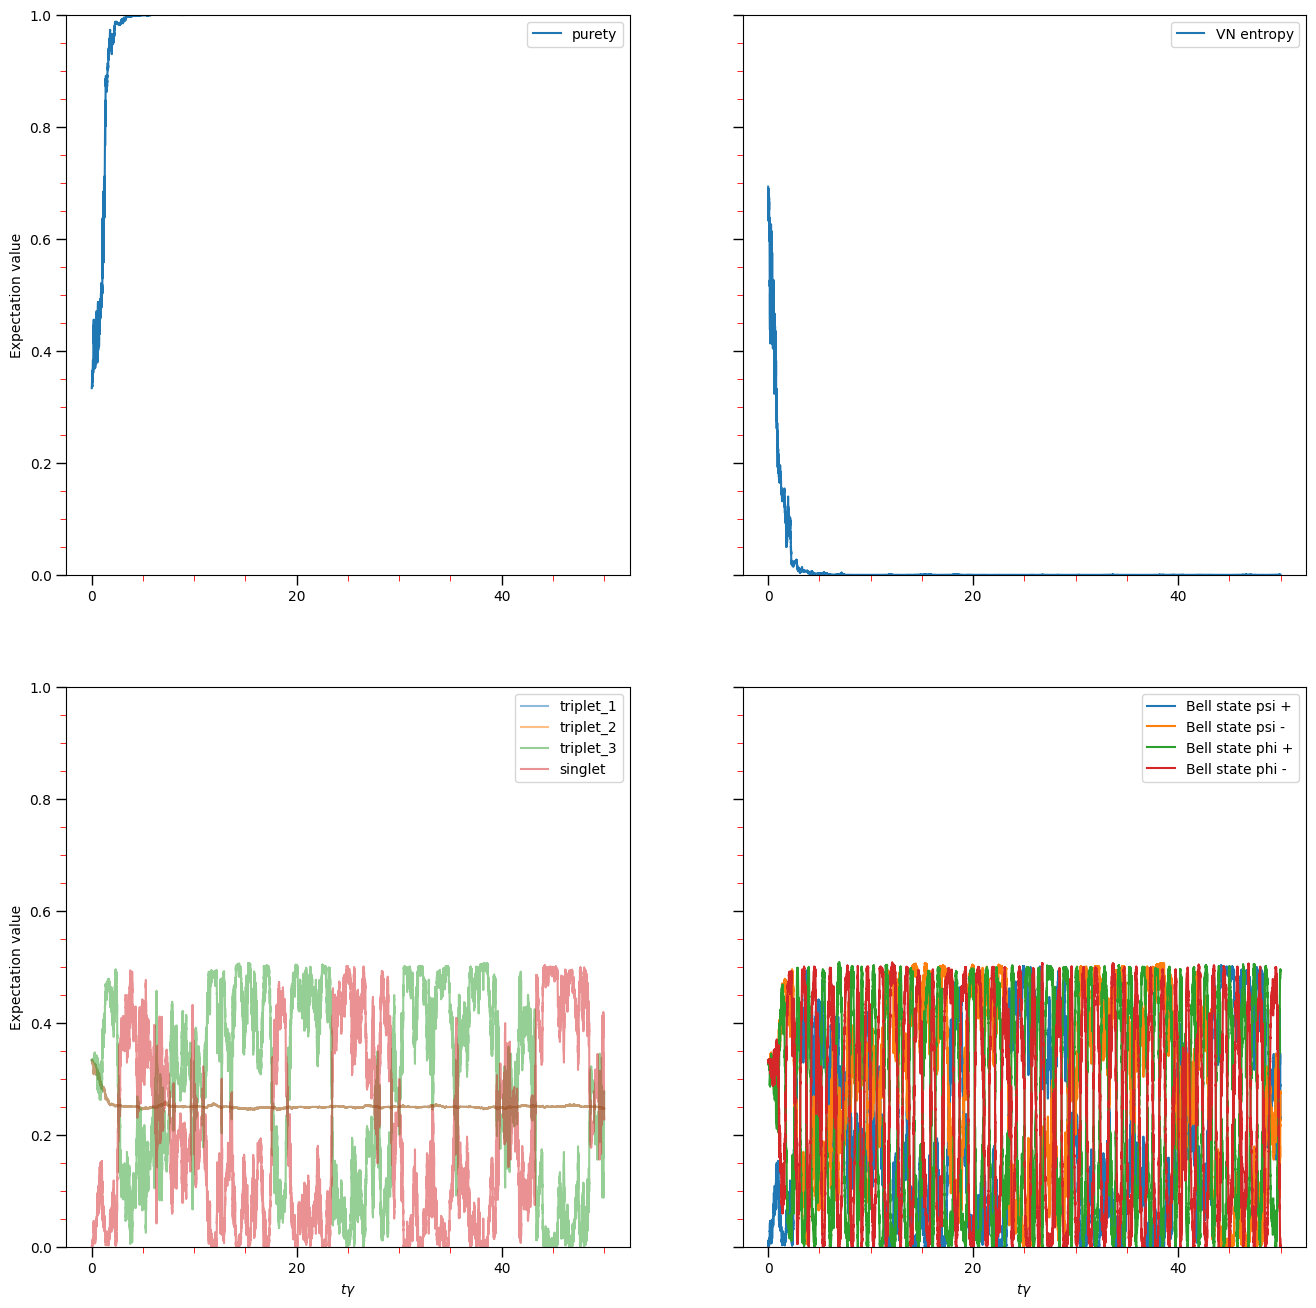

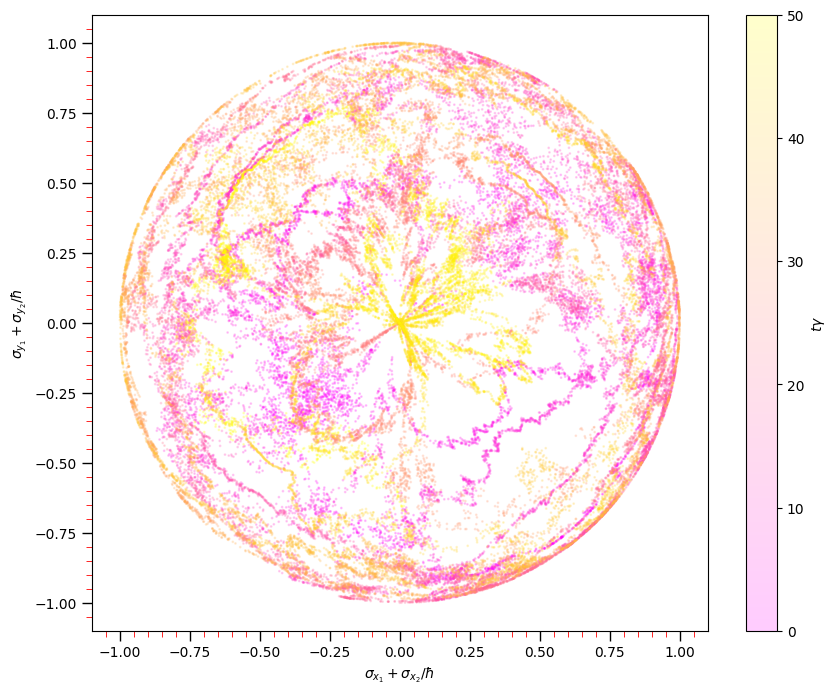

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(16, 16), sharey=True)















ax[0, 0].plot(times_gamma, purety, label='purety')
ax[0, 1].plot(times_gamma, entropy, label='VN entropy')
ax[0, 0].set_ylim(0, 1)
ax[0, 1].set_ylim(0, 1)
ax[1, 0].plot(times_gamma, Experiment.expectation[:,9], label='triplet_1', alpha=0.5)
ax[1, 0].plot(times_gamma, Experiment.expectation[:,10], label='triplet_2', alpha=0.5)
ax[1, 0].plot(times_gamma, Experiment.expectation[:,11], label='triplet_3', alpha=0.5)
ax[1, 0].plot(times_gamma, Experiment.expectation[:,12], label='singlet', alpha=0.5)
ax[1, 0].set_ylim(0, 1)
ax[0, 0].set_ylabel('Expectation value')
ax[1, 0].set_ylim( 0, 1)
ax[1, 1].plot(times_gamma, Experiment.expectation[:,14], label='Bell state psi +')
ax[1, 1].plot(times_gamma, Experiment.expectation[:,15], label='Bell state psi -')
ax[1, 1].plot(times_gamma, Experiment.expectation[:,16], label='Bell state phi +')
ax[1, 1].plot(times_gamma, Experiment.expectation[:,17], label='Bell state phi -')
ax[1, 0].set_ylabel('Expectation value')
ax[1, 0].set_xlabel('$t\gamma$')
ax[1, 1].set_xlabel('$t\gamma$')

for i in range(2):
    for j in range(2):
        ax[i, j].xaxis.set_major_locator(MultipleLocator(20))
        ax[i, j].xaxis.set_minor_locator(MultipleLocator(5))
        ax[i, j].yaxis.set_major_locator(MultipleLocator(0.20))
        ax[i, j].yaxis.set_minor_locator(MultipleLocator(0.05))
            #ax.xaxis.set_major_formatter('{x:.0f}')

        ax[i, j].tick_params(which='major', width=1)
        ax[i, j].tick_params(which='major', length=7)
        ax[i, j].tick_params(which='minor', length=4, color='r')







ax[0, 0].legend()
ax[0, 1].legend()
ax[1, 0].legend()
ax[1, 1].legend()


plt.show()


color_map = plt.get_cmap('tab10')

color = color_map(np.linspace(0, 1, len(Experiment.expectation[:,0])))
fig, ax = plt.subplots(1, figsize=(10, 8))
ax_1 = ax.scatter(Experiment.expectation[:,7], Experiment.expectation[:,8], alpha=0.2, c=times_gamma, cmap='spring', s=1)
ax.set_xlabel('$\sigma_{x_1} + \sigma_{x_2} / \hbar$')
ax.set_ylabel('$\sigma_{y_1} + \sigma_{y_2} / \hbar$')
ax.set_aspect('equal')
ax.xaxis.set_major_locator(MultipleLocator(0.25))
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.set_major_locator(MultipleLocator(0.25))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    #ax.xaxis.set_major_formatter('{x:.0f}')

ax.tick_params(which='major', width=1)
ax.tick_params(which='major', length=7)
ax.tick_params(which='minor', length=4, color='r')
fig.colorbar(ax_1, label='$t\gamma$')

fig.savefig(f'12_may_2_spin_total_spin_t_{t_gamma}_type_{entaglement}.png')

plt.show()



## Estimating the magnetic field

In [22]:
Y = Experiment.detection_record


c_1_1_HMM = c_1 #lambda i: sigma_x_1 * 0.1
#c_2_1_HMM = c_2_1#lambda i: sigma_y_1 * 0.1 #np.sqrt(gamma_decay) * sigma_m_1 # decay of qubit out of the cavity
#c_3_1_HMM = c_3_1#lambda i: sigma_z_1 * 0.1 #np.sqrt(gamma_phi / 2) * sigma_z_1 # dephasing of qubit
c_out_1_1_HMM = c_out_1
c_out_1_1_e_HMM = c_out_1_e
c_out_1_1_dag_HMM = c_out_1_dag
c_out_1_1_e_dag_HMM = c_out_1_e_dag

c_1_2_HMM = c_2 #lambda i: sigma_x_2 * 0.1 #sigma_m_2 * np.sqrt(gamma_purcell(Delta_n_2_posible[i]))
#c_2_2_HMM = c_2_2 #lambda i: sigma_y_2 * 0.1#np.sqrt(gamma_decay) * sigma_m_2 # decay of qubit out of the cavity
#c_3_2_HMM = c_3_2 #lambda i: sigma_z_2 * 0.1#np.sqrt(gamma_phi / 2) * sigma_z_2 # dephasing of qubit
c_out_1_2_HMM = c_out_2
c_out_1_2_e_HMM = c_out_2_e
c_out_1_2_dag_HMM = c_out_2_dag
c_out_1_2_e_dag_HMM = c_out_2_e_dag

rho_0 = qt.tensor(qt.maximally_mixed_dm(N_dim), qt.maximally_mixed_dm(N_dim)) #qt.tensor(qt.basis(N_dim, 0), qt.basis(N_dim, 0))

rho_HMM = [rho_0 / N_states for _ in range(N_states)]



sigma_x_1_time = [sigma_x_1 for i in range(N_t)]
sigma_x_2_time = [sigma_x_2 for i in range(N_t)]






H_1_HMM = lambda i : 1/2 * (sigma_x_1 * Delta_n_1_posible[i, 0] + sigma_y_1 * Delta_n_1_posible[i, 1] + sigma_z_1 * Delta_n_1_posible[i, 2])
H_2_HMM = lambda i : 1/2 * (sigma_x_2 * Delta_n_2_posible[i, 0] + sigma_y_2 * Delta_n_2_posible[i, 1] + sigma_z_2 * Delta_n_2_posible[i, 2])
H_cupling_HMM = lambda i : cupling_strength * Delta_n_1_posible[i] @ Delta_n_2_posible[i]

H_HMM = [H_1_HMM(i) + H_2_HMM(i) + H_cupling_HMM(i) for i in range(N_states)]


#c_ops_HMM = [[c_1_1_HMM(i), c_2_1_HMM(i), c_3_1_HMM(i), c_1_2_HMM(i), c_2_2_HMM(i), c_3_2_HMM(i)] for i in range(N_states)]

c_ops_HMM = [[c_1_1_HMM(i), c_1_2_HMM(i)] for i in range(N_states)]
#c_ops_HMM = [[] for i in range(N_states)]
if entaglement:
    sc_ops_HMM_w = [[c_out_1_1_e_HMM(i), c_out_1_2_e_HMM(i)] for i in range(N_states)]
    sc_ops_HMM_c = [[0 * c_out_1_1_e_HMM(i), 0 * c_out_1_2_e_HMM(i)] for i in range(N_states)]
    e_ops_HMM = [[c_out_1_1_e_HMM(i) + c_out_1_1_e_dag_HMM(i), c_out_1_2_e_HMM(i) + c_out_1_2_e_dag_HMM(i)] for i in range(N_states)]   
else:
    sc_ops_HMM_w = [[c_out_1_1_HMM(i), c_out_1_2_HMM(i)] for i in range(N_states)]
    sc_ops_HMM_c = [[0 * c_out_1_1_HMM(i), 0 * c_out_1_2_HMM(i)] for i in range(N_states)]
    e_ops_HMM = [[c_out_1_1_HMM(i) + c_out_1_1_dag_HMM(i), c_out_1_2_HMM(i) + c_out_1_2_dag_HMM(i)] for i in range(N_states)]

### jump oporators for the HMM states

#r_HMM_jump = r_HMM_sim.copy()
#r_HMM_jump = r_HMM_jump - np.eye(N_states) * np.diag(r_HMM_jump) # remove the diagonal elements
#r = p * np.eye(N+1, k=-1) + np.eye(N+1, k=1) # transition matrix of the HMM


J_index = []

for i in range(N_states):
    for j in range(N_states):
        if i != j:#if r_HMM_jump[i, j] != 0:
            if r_HMM[i, j] != 0:
                J_index.append([i, j])
                #J_HMM_list.append(qt.tensor(qt.qeye(2), np.sqrt(r_HMM_jump[i, j]) * qt.basis(N_states, j) * qt.basis(N_states, i).dag()))
            #J_HMM_list.append(qt.tensor(np.sqrt(r_HMM_sim[i, j]) * qt.basis(N_states, j) * qt.basis(N_states, i).dag(), qt.qeye(2)))
    
#print(J_HMM_list)
J_index = np.array(J_index)



#n_op = qt.tensor(qt.destroy(N_states).dag() * qt.destroy(N_states), I_2q)






#c_out_part_1 = qt.tensor(sigma_m,  qt.qdiags(1j * g / (kappa + 1j * (Delta_r - Delta_n_posible))))

#c_out_0_0 = np.sqrt(2 * kappa_1) * (alpha - 1j * g * sigma_m_1/ (kappa + 1j * (Delta_r - Delta_n_1_posible[0]))) - beta

#c_out_1_1 = np.sqrt(2 * kappa_1) * (alpha - 1j * g * sigma_m_1/ (kappa + 1j * (Delta_r - Delta_n_1_posible[1]))) - beta

#c_out_0 = qt.tensor(qt.basis(N_states, 0) * qt.basis(N_states, 0).dag(), c_out_0_0) # the output signal expected for the first HMM state of the first spin
#c_out_1 = qt.tensor(qt.basis(N_states, 1) * qt.basis(N_states, 1).dag(), c_out_1_1)


#print('size of rho_HMM', rho_HMM.shape[0])

#Y -= np.mean(Y)





Experiment_estimater = PQS.Experiment_estimation(H_HMM, rho_HMM, times, c_ops_HMM, sc_ops_HMM_w, sc_ops_HMM_c, N_states, r_HMM, J_index, e_ops=e_ops_HMM, timedependent_H=False)
Experiment_estimater.solve(Y, methode=methode)






#print(PQS_estimater.rho[10], (PQS_estimater.rho[10] * n_op).tr())





true_value 4.98


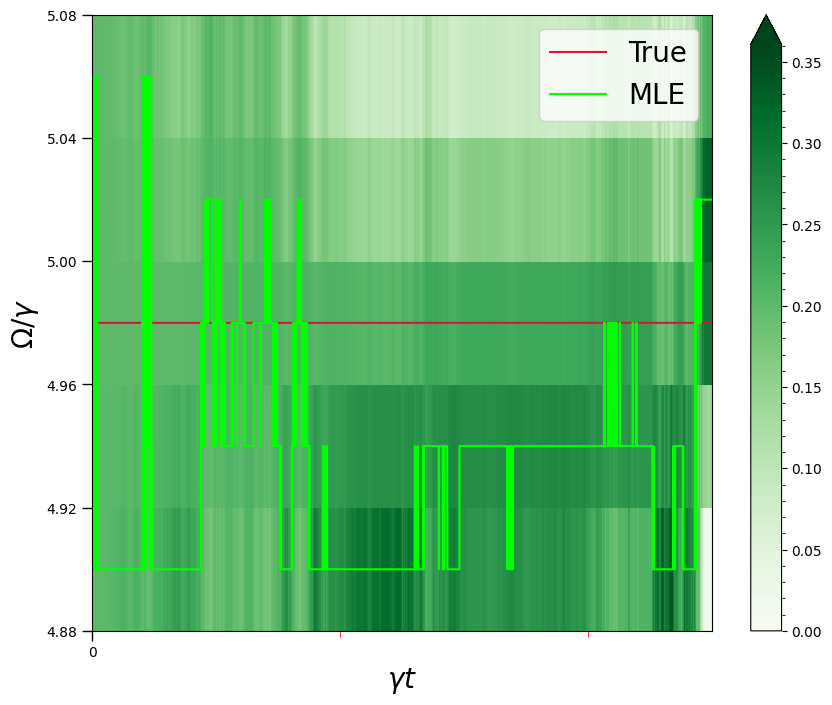

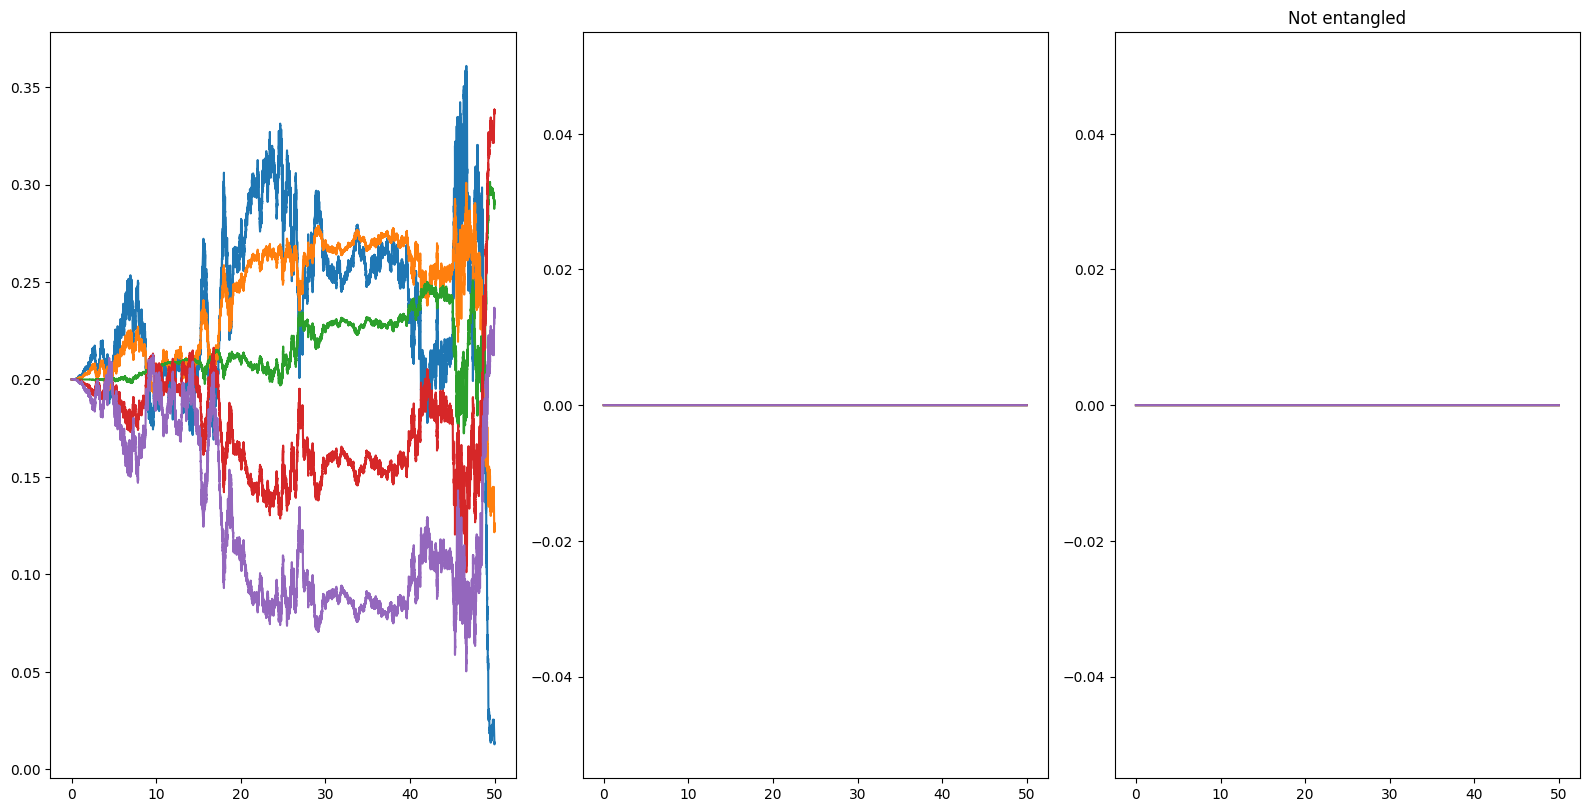

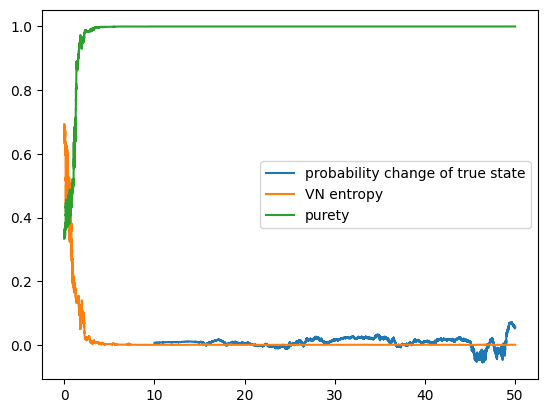

m_fit :  0.00010469088043100019 +-  0.12923054945447926
b_fit :  1.9610227217978365e-06 +-  0.00015362084030114817


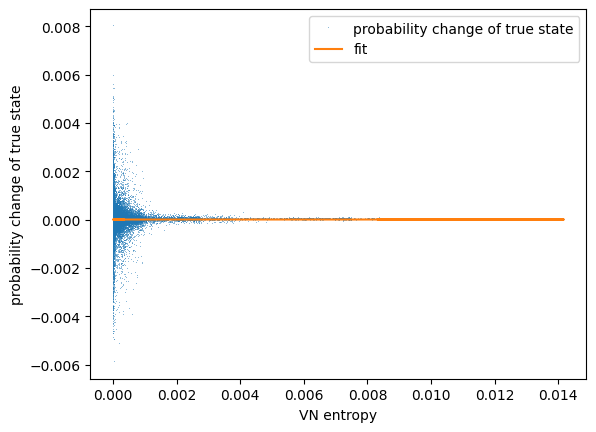

In [23]:
from scipy.signal import savgol_filter
if entaglement=='entaglement':
    title = 'Entangled'
else:
    title = 'Not entangled'


def plot_estimate_hist(time, estimate_signal, True_signal, N_rabi, rabi_min, rabi_max, rabi_step, save=False, filename='test', cmap='plasma'):
    #fig, ax = plt.subplots(figsize=(16, 8))
    text_size = 20
    fig, ax = plt.subplots(figsize=(10, 8))
    extent=(rabi_min, rabi_max, 0, times)
    c = ax.imshow(estimate_signal.T, aspect='auto', extent=[0, 
                    time[-1], rabi_min - rabi_step / 2, rabi_max - rabi_step / 2], origin='lower', 
                    cmap=cmap, vmin=0, interpolation='none')
    
    ticks = np.linspace(rabi_min, rabi_max, N_rabi, endpoint=True)
    
    
    ax.xaxis.set_major_locator(MultipleLocator(100))
    ax.xaxis.set_minor_locator(MultipleLocator(20))
    ax.yaxis.set_major_locator(MultipleLocator(rabi_step))
    #ax.yaxis.set_minor_locator(MultipleLocator(0.2))
    #ax.xaxis.set_major_formatter('{x:.0f}')

    ax.tick_params(which='major', width=1)
    ax.tick_params(which='major', length=7)
    ax.tick_params(which='minor', length=4, color='r')

    #plt.yticks(ticks)

    converter = lambda x: x * rabi_step + rabi_min

    print('true_value', converter(True_signal[-1]) )
    
    
    MLE = np.argmax(estimate_signal, axis=1)
   
    ax.plot(time, converter(True_signal), label='True', color='crimson')
    ax.plot(time, converter(MLE), label='MLE', color='lime')

    ax.set_xlabel('$\gamma t$', fontsize=text_size)
    ax.set_ylabel('$\Omega / \gamma$', fontsize=text_size)
    ax.legend(fontsize=text_size)
    cbar = fig.colorbar(c, ax=ax, extend='max')
    cbar.minorticks_on()
    
    if save:
        file_path = f'{filename}.png'
        plt.savefig(file_path)
    plt.show()

plot_estimate_hist(times_gamma, Experiment_estimater.P_n_rho.real, HMM_state_index_new, N_states, m_min, m_max, m_step, save=save, filename='21_november_not_entangled_hist', cmap='Greens')
PQS.plot_estimate_trajectory(times_gamma, N_states, Experiment_estimater, title, save=save, filename='21_november_not_entangled_trajectory')



d_rho_n = np.diff(Experiment_estimater.P_n_rho.real, axis=0)


def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

window = 10000


d_rho_n_smooth = moving_average(d_rho_n[:,HMM_state_index_new[0]], n=window) * window




plt.plot(times_gamma[window:], d_rho_n_smooth, label='probability change of true state')
plt.plot(times_gamma, entropy, label='VN entropy')
plt.plot(times_gamma, purety, label='purety')
plt.legend()
plt.show()


mask_purety = np.array(purety[1:]) > 0.99

times_gamma_purety = times_gamma[1:][mask_purety]
d_rho_n_purety = d_rho_n[:, HMM_state_index_new[0]][mask_purety]
entropy_purety = np.array(entropy[1:])[mask_purety]

def lin_fit(x, m, b):
    return m * x + b

least_squares = LeastSquares(entropy_purety, d_rho_n_purety, np.ones(len(entropy_purety)) * np.sqrt(dt), lin_fit)

m = Minuit(least_squares, m=0, b=0)

m.migrad()

m_fit = m.values[0]
b_fit = m.values[1]

print('m_fit : ', m_fit, '+- ', m.errors[0])
print('b_fit : ', b_fit, '+- ', m.errors[1])








plt.plot(entropy_purety, d_rho_n_purety, ',', label='probability change of true state', alpha=0.5)
plt.plot(entropy_purety, lin_fit(entropy_purety, m_fit, b_fit), label='fit')
plt.xlabel('VN entropy')
plt.ylabel('probability change of true state')
plt.legend()
plt.show()








#eigenvalues = np.zeros((N_t, 4), dtype=complex)
#for i in range(N_t):
#    eigenvalues[i] = np.linalg.eigvals(Experiment.rho[i].full())

#fig, ax = plt.subplots(1, 1, figsize=(16, 6))

#ax.plot(times_gamma, eigenvalues[:,0].real, label='1')
#ax.plot(times_gamma, eigenvalues[:,1].real, label='2')
#ax.plot(times_gamma, eigenvalues[:,2].real, label='3')
#ax.plot(times_gamma, eigenvalues[:,3].real, label='4')
#ax.set_yscale('log')
#ax.set_title('Eigenvalues')
#plt.show()


#plt.plot(times_gamma, Experiment_estimater.expectation[:,3], label='Expectation value 3')

## Quantefying the error on the estimate

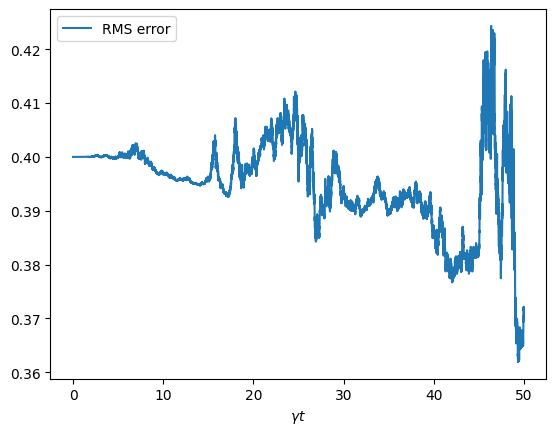

In [24]:
def RMS(True_x, estimated_x):
    for i in range(len(estimated_x)):
        estimated_x[i, True_x[i]] += - 1
    return np.sqrt(np.mean((estimated_x) ** 2, axis=1))



simulation_results = Experiment_estimater.P_n_rho.real
true_results = HMM_state_index_new



error = RMS(true_results, simulation_results)

plt.plot(times_gamma, error, label='RMS error')
plt.xlabel('$\gamma t$')
plt.legend()
plt.show()

# Testing Hamiltonians

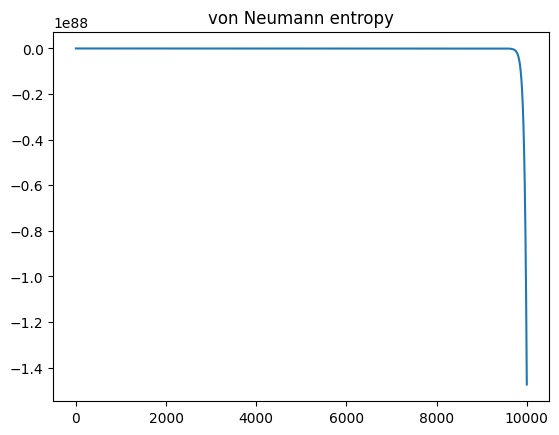

In [25]:
N_dim = 2
qubit_1 = (qt.basis(N_dim, 0) + qt.basis(N_dim, 1)) / np.sqrt(2)
qubit_1 = qubit_1 * qubit_1.dag()
qubit_2 = (qt.basis(N_dim, 0))# + qt.basis(2, 1))
qubit_2 = qubit_2 * qubit_2.dag()

c_x = qt.Qobj([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]], dims=[[N_dim, N_dim], [N_dim, N_dim]])
c_y = qt.Qobj([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, -1j], [0, 0, 1j, 0]], dims=[[N_dim, N_dim], [N_dim, N_dim]])

test_state = qt.tensor(qubit_1, qubit_2)

N_test = 10000
N_applied = np.arange(N_test)
entropy_von_neu = np.zeros(N_test)

measurment_strength = 0.01

new_oporator = np.sqrt(1 - measurment_strength ** 2) * qt.qeye_like(test_state) + measurment_strength * c_x


for i in range(N_test):
    test_state = new_oporator * test_state * new_oporator.dag()
    entropy_von_neu[i] = qt.entropy.entropy_vn(test_state)

plt.plot(N_applied, entropy_von_neu)
plt.title('von Neumann entropy')
plt.show()



#print('test state', test_state)
#print('test state von neumann entropy', qt.entropy.entropy_vn(test_state))
#print('test state cnot', c_x * test_state)
#print('test state cnot von neumann entropy', qt.entropy.entropy_vn(c_x * test_state))


In [26]:
sigma_x = qt.sigmax()
sigma_y = qt.sigmay()

r_1 = np.random.random_sample(1000)
theta = np.random.random_sample(1000) * np.pi * 2
r_2 = np.sqrt(1 - r_1 ** 2)

alpha = r_1
beta = r_2 * np.exp(1j * theta)

psi = alpha * qt.basis(2, 0) + beta * qt.basis(2, 1)

sigma_x * psi





TypeError: unsupported operand type(s) for *: 'numpy.ndarray' and 'Qobj'

In [ ]:
x_sum = (sigma_x_1 + sigma_x_2)
state_new = (sigma_x_1 + sigma_x_2) * singlet_state

print('x_sum_unitery', x_sum.dag() * x_sum)
print('sigma_x_unitery', sigma_x.dag() * sigma_x)
print('state_new', state_new)

x_sum_unitery Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0.5 0.  0.  0.5]
 [0.  0.5 0.5 0. ]
 [0.  0.5 0.5 0. ]
 [0.5 0.  0.  0.5]]
sigma_x_unitery Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0.25 0.  ]
 [0.   0.25]]
state_new Quantum object: dims=[[2, 2], [1, 1]], shape=(4, 1), type='ket', dtype=Dense
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]]
